# Deep Neural Network 
    - This is a implementation from scratch of neural network with scalable network architecture
    - Used Numpy for matrix functions
    
* Author: Jonver Oro

In [1]:
# import models
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import sklearn.datasets
from math import log
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score,log_loss

In [2]:
# test_data = load_breast_cancer()
# x = test_data.data
# y = test_data.target

# Generate data
x, y = sklearn.datasets.make_moons(1000, noise=0.20)
#sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=2)
X_train = x
Y_train = y


In [3]:
#create neural network layer object class
class activations:
    def relu(self,Z):
        R = np.maximum(0, Z)
        return R
    
    def sigmoid(self,Z):
        S = 1 / (1 + np.exp(-Z))
        return S
    
    def tanh(self,x):
        t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        return t
    
    def d_tanh(self,t):
        dt=1-t**2
        return dt
    
    def d_sigmoid(self,Z):
        dS = Z * (1 - Z)
        return dS

    def d_relu(self,z):
        dZ= np.where(z <= 0, 0, 1)
        return dZ
    
class cost_functions:
    
    def cross_entropy(self,AL,Y):
        #compute cross entropy cost
        m = Y.shape[0] # shape of layer
        cross_entropy = np.multiply(np.log(AL),Y)+np.multiply(1-Y,np.log(1-AL)) #cross entropy formula
        cross_entropy = - np.sum(cross_entropy)/m
        cost = np.squeeze(cross_entropy)
        return cost
    def cost_prime(self,AL,Y):
        cost = (Y-AL)**2
        cost = np.sum(cost)
        cost = np.squeeze(cost)
        return cost
    
    def mse(self,AL,Y):
        n = AL.shape[1]
        cost = (1./(2*n)) * np.sum((Y - AL) ** 2)
        return cost
    
    def sum_squared(self,AL,Y):
        return (np.sum(AL-Y))**2

class layer:
    def __init__(self,w,b,activation=None,last=True):
        self.W = w # weights
        self.B = b # bias
        self.acti = activation
        self.last = last
        
    def forward(self,A):
        Z = np.dot(A,self.W)+self.B
        if self.acti == 'relu':
            A = activations().relu(Z)
        elif self.acti == 'sigmoid':
            A = activations().sigmoid(Z)
        elif self.acti == 'tanh':
            A = activations().tanh(Z)
            
        return A,Z
    
    def activation_derivative(self,A):
        if self.acti == 'relu':
            dA = activations().d_relu(A)
        elif self.acti == 'sigmoid':
            dA = activations().d_sigmoid(A)
        elif self.acti == 'tanh':
            dA = activations().d_tanh(A)
        return dA
    
    def backward(self,A,A_prev,d_prev):
        
        dA = self.activation_derivative(A)
        if self.last == True:
            dW = np.dot(A_prev.T, (dA * d_prev))
            d = self.W.dot(dA.T * d_prev.T)
        else:
            dW = np.dot(A_prev.T, (d_prev.T * dA))
            d = self.W.dot(dA.T * d_prev)
        dB = np.sum(dW, axis=0)
        
        return dW,dB,d

### Train Simple Neural Network 

In [4]:
#basic neural network with 3 layers
epochs = 4000
epsilon = 0.0001
#dimensions
l1_dim = x.shape[1]
l2_dim = 4
l3_dim = 2
output_dim = 1

#create weights and biases
w1 = np.random.rand(l1_dim,l2_dim)
b1 = np.random.rand(l2_dim)
w2 = np.random.rand(l2_dim,l3_dim)
b2 = np.random.rand(l3_dim)
w3 = np.random.rand(l3_dim,output_dim)
b3 = np.random.rand(output_dim)

for e in range(0,epochs):
    #FORWARD PASS
    '''
        Formula for forward pass
        
        let: σ(x) = activation function, A = activation,x = inputs, 
                    w = weights, b = bias
                    
            A = σ(w * x + b)
    '''
    A1,Z1 = layer(w1,b1,activation='relu').forward(x) # activation values
    A2,Z2 = layer(w2,b2,activation='relu').forward(A1) # activation values
    A3,Z3 = layer(w3,b3,activation='sigmoid').forward(A2) # activation values

    #BACK PROPAGATION
    '''
        Formula for Back Propagation
        
        let: L = layer, l = index of current layer, ŷ= predicted vals,  δ = delta 
             δA = derivative of activation function, c = cost,ΔW = weights derivative,
             ΔG = gradients derivative
        
        For 1st layer:
            c = (y - ŷ) * 2
            ΔW[l] = A[l-1] * c * δA[l]
            δ[l] = w[l] * δA[l] * c
            
        For next layers:
            ΔW[l] = A[l-1] * δ[l+1] * δA[l]
            δ[l] = w[l] * δA[l] * δ[l+1]
        
        Bias Derivative Formula
            δB = ∑ΔW[l]
            
        Gradient decent for updating gradients:
            ΔG := - lr * ∇g
            
    '''
    y = y.reshape(A3.shape)
    cost = (y-A3)*2
    dA3 = activations().d_sigmoid(A3)
    dW3 = np.dot(A2.T, (dA3 * cost))
    d3 = w3.dot(dA3.T * cost.T)

    dA2 = activations().d_relu(A2)
    dW2 = np.dot(A1.T, (d3.T * dA2))
    d2 = w2.dot(dA2.T*d3)
    
    dA1 = activations().d_relu(A1)
    dW1 = np.dot(x.T, (d2.T * dA1))
    d1 = w1.dot(dA1.T*d2)
  
    dB3 = np.sum(dW3, axis=0) 
    dB2 = np.sum(dW2, axis=0) 
    dB1 = np.sum(dW1, axis=0) 
    

    #WEIGHTS AND BIASES UPDATE
    w3 += epsilon * dW3
    b3 += epsilon * dB3
    w2 += epsilon * dW2
    b2 += epsilon * dB2
    w1 += epsilon * dW1
    b1 += epsilon * dB1

    if (e+1) % 100 == 0:
        y_pred = A3.T
        y_pred = y_pred[0]
        score = log_loss(y,y_pred)
        print(score)
        #print(dB1)
        
    if e == epochs-1:
        print('----Weights----')
        print(w1)
        print(w2)
        print(w3)

        print('----Final Outputs----')
        for i in range(0,int(len(y_pred)/5)):
            print(f'{y.T[0][i]}-{y_pred[i]}')
            

0.6233858741736069
0.5697714738798265
0.5141420096553502
0.4584664637000829
0.40132259475934867
0.3648845423813976
0.3395797718254811
0.32078998877160597
0.30753927731189923
0.2984194077120843
0.29234569478581734
0.28816762683793046
0.28533939179877393
0.28332548771658456
0.28166767072420396
0.28047499003362736
0.2795177084556354
0.278719161062533
0.27805060870254794
0.2774725494760207
0.27697495362796
0.27645683998781045
0.27599701202203997
0.27560086353887153
0.27520322322525653
0.27482653910195803
0.27444849920855835
0.27410393823636925
0.2738110149679837
0.2735506741615293
0.27331551106717017
0.27309432131043393
0.27289837838636316
0.2724906849378627
0.2722165438815799
0.27206752014788776
0.27189713414983896
0.27175103750566115
0.27169787050087973
0.2716860842147601
----Weights----
[[-0.17762298  0.2842099   0.28757528  0.36749103]
 [ 1.6686854   0.53185792 -0.03241047 -0.79630933]]
[[-0.79546709  1.05500503]
 [ 0.61749165  0.68744297]
 [ 1.66945326  0.66944532]
 [ 1.4920886   0.49

### Train the Neural Network with scable architecture

creating weights and biases
Epoch: 100 Loss: 0.697551459977479
Epoch: 200 Loss: 0.6652536726240843
Epoch: 300 Loss: 0.6451007871914587
Epoch: 400 Loss: 0.6165807009378045
Epoch: 500 Loss: 0.5654787384522411
Epoch: 600 Loss: 0.47219131723618696
Epoch: 700 Loss: 0.4064921694360165
Epoch: 800 Loss: 0.37707905929238267
Epoch: 900 Loss: 0.3623741169877632
Epoch: 1000 Loss: 0.3533799424577017
Epoch: 1100 Loss: 0.3463241880733343
Epoch: 1200 Loss: 0.340462951935137
Epoch: 1300 Loss: 0.3362397197470868
Epoch: 1400 Loss: 0.33221560987072796
Epoch: 1500 Loss: 0.3272388899427922
Epoch: 1600 Loss: 0.3191706329323338
Epoch: 1700 Loss: 0.2964148948779128
Epoch: 1800 Loss: 0.28513659374418476
Epoch: 1900 Loss: 0.27135996390625655
Epoch: 2000 Loss: 0.25886394721125955
Epoch: 2100 Loss: 0.2469965874069153
Epoch: 2200 Loss: 0.2355583579287141
Epoch: 2300 Loss: 0.22505399419257593
Epoch: 2400 Loss: 0.21671852650768236
Epoch: 2500 Loss: 0.20998734500596675
Epoch: 2600 Loss: 0.20477071157847124
Epoch: 2700

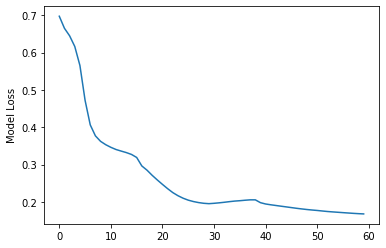

In [5]:
epochs = 6000
learn_rate = 0.0001
#define neural network architecture
nn_layers = [
    {'l_shape':x.shape[1],'activation':'relu'},
    {'l_shape':6,'activation':'relu'},
    {'l_shape':4,'activation':'relu'},
    {'l_shape':2,'activation':'relu'},
    {'l_shape':1,'activation':'sigmoid'}
]
cost_l = []
L = len(nn_layers)
weights = [0]*(len(nn_layers)-1)
biases = [0]*(len(nn_layers)-1)
activs = [0]*(len(nn_layers)-1)
deltas = [0]*(len(nn_layers)-1)
dActivs = [0]*(len(nn_layers)-1)
#train neural network
for e in range(0,epochs):
    if e == 0:
        print('creating weights and biases')
        for l in range(0,L-1):
            w = np.random.rand(nn_layers[l]['l_shape'],nn_layers[l+1]['l_shape']) #weight shape LixLi+1
            weights[l] = w
            b = np.random.rand(nn_layers[l+1]['l_shape'])#bias shape Li+1
            biases[l]= b
    
    #forward propagation
    for l in range(1,L):
        if l == 1:
            aL,aZ = layer(weights[l-1],biases[l-1],activation=nn_layers[l]['activation']).forward(X_train) #forward activation function
            activs[l-1] = aL
        else:
            aL,aZ = layer(weights[l-1],biases[l-1],activation=nn_layers[l]['activation']).forward(activs[l-2]) #forward activation function
            activs[l-1] = aL
            
            
    #backward propagation
    for l in range(L-2,-1,-1):
        if l == L-2:
            last_layer = True
        else:
            last_layer = False
        layer_cls = layer(weights[l],biases[l],activation=nn_layers[l+1]['activation'],last=last_layer)
        if l == L-2:
            AL = activs[l]
            Y_train = Y_train.reshape(AL.shape)
            cost = (Y_train-AL)*2
            d_prev = cost
            dA = layer_cls.activation_derivative(activs[l])
        else:
            dA = layer_cls.activation_derivative(activs[l])
            d_prev = deltas[l+1]
            
        if l != 0:  
            dW,dB,d = layer_cls.backward(dA,activs[l-1],d_prev) #backward prop function
        else:
            dW,dB,d = layer_cls.backward(dA,X_train,d_prev) #backward prop function
        deltas[l] = d       
        weights[l] += learn_rate * dW
        biases[l] += learn_rate * dB
        
    if (e+1) % 100 == 0:
        y_pred = activs[L-2].T
        y_pred = y_pred[0]
        score = log_loss(y,y_pred)
        cost_l.append(score)
        print(f'Epoch: {e+1} Loss: {score}')

plt.plot(cost_l)
plt.ylabel('Model Loss')
plt.show()